## Model / Trening

In [9]:
!pip install -q tensorflow opencv-python

import os, json, shutil, zipfile
import numpy as np
import tensorflow as tf
from google.colab import files
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
from collections import Counter

print("Wybierz plik ZIP z danymi.")
plik = files.upload()

zipSciezka = list(plik.keys())[0]
extractDir = '/content/logos'
shutil.rmtree(extractDir, ignore_errors=True)

with zipfile.ZipFile(zipSciezka, 'r') as zipRef:
    zipRef.extractall(extractDir)
print(f"Rozpakowano do: {extractDir}")

shutil.rmtree(os.path.join(extractDir, 'dataset'), ignore_errors=True)
shutil.rmtree(os.path.join(extractDir, '.ipynb_checkpoints'), ignore_errors=True)
print("Foldery w /content/logos:", os.listdir(extractDir))

ROZMIAR_OBRAZU = (224, 224)
PARTIA = 32
EPOKI = 15
EPOKI_POMOCNICZE = 15
SCIEZKA_MODELU = '/content/logotypyMarek.keras'
SCIEZKA_ETYKIET = '/content/labelsy.json'

datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.15,
    horizontal_flip=True
)

train_data = datagen.flow_from_directory(
    extractDir,
    target_size=ROZMIAR_OBRAZU,
    batch_size=PARTIA,
    class_mode='categorical',
    subset='training',
    shuffle=True
)
val_data = datagen.flow_from_directory(
    extractDir,
    target_size=ROZMIAR_OBRAZU,
    batch_size=PARTIA,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

liczbaObrazkow = Counter(train_data.classes)
maksimum = max(liczbaObrazkow.values())
wagiKlas = {cls: maksimum/ct for cls, ct in liczbaObrazkow.items()}
print("wagi klas:", wagiKlas)

bazowyModel = MobileNetV2(input_shape=(ROZMIAR_OBRAZU[0], ROZMIAR_OBRAZU[1], 3),
                   include_top=False, weights='imagenet')
bazowyModel.trainable = False

inputs = layers.Input(shape=(ROZMIAR_OBRAZU[0], ROZMIAR_OBRAZU[1], 3))
x = bazowyModel(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(train_data.num_classes, activation='softmax')(x)
model = models.Model(inputs, outputs)

model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

early = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)

print("Etap 1: trening klasyfikatora")
model.fit(train_data,
          validation_data=val_data,
          epochs=EPOKI,
          callbacks=[early],
          class_weight=wagiKlas,
          verbose=1)

bazowyModel.trainable = True
for layer in bazowyModel.layers[:-30]:
    layer.trainable = False

model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

print("Etap 2: dostrajanie")
model.fit(train_data,
          validation_data=val_data,
          epochs=EPOKI_POMOCNICZE,
          callbacks=[early],
          class_weight=wagiKlas,
          verbose=1)

labels = list(train_data.class_indices.keys())
model.save(SCIEZKA_MODELU)
with open(SCIEZKA_ETYKIET, 'w') as f:
    json.dump(labels, f)

print("\nZapisano model:", SCIEZKA_MODELU)
print("Zapisano etykiety:", SCIEZKA_ETYKIET)
print("Kolejność klas:", labels)


Wybierz plik ZIP z danymi.


Saving dataset.zip to dataset.zip
Rozpakowano do: /content/logos
Foldery w /content/logos: ['BurgerKing', 'Starbucks', 'McDonalds', 'Subway', 'KFC', 'CostaCoffee']
Found 524 images belonging to 6 classes.
Found 128 images belonging to 6 classes.
wagi klas: {np.int32(0): 1.0505050505050506, np.int32(1): 1.625, np.int32(2): 1.223529411764706, np.int32(3): 1.0, np.int32(4): 1.1304347826086956, np.int32(5): 1.3}
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Etap 1: trening klasyfikatora


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step - accuracy: 0.1993 - loss: 2.4324 - val_accuracy: 0.8359 - val_loss: 0.7227
Epoch 2/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 10s 593ms/step - accuracy: 0.5772 - loss: 1.4262 - val_accuracy: 0.8828 - val_loss: 0.4088
Epoch 3/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 10s 587ms/step - accuracy: 0.7229 - loss: 0.9682 - val_accuracy: 0.8984 - val_loss: 0.3008
Epoch 4/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 11s 620ms/step - accuracy: 0.7637 - loss: 0.7852 - val_accuracy: 0.9219 - val_loss: 0.2707
Epoch 5/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 11s 641ms/step - accuracy: 0.7679 - loss: 0.7600 - val_accuracy: 0.9531 - val_loss: 0.2029
Epoch 6/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 11s 636ms/step - accuracy: 0.8616 - loss: 0.5381 - val_accuracy: 0.9609 - val_loss: 0.2041
Epoch 7/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 11s 629ms/step - accuracy: 0.8617 - loss: 0.5532 - val_accuracy: 0.9375 - val_loss: 0.1893
Epoch 8/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 11s 624ms/step - accuracy: 0.8772 - loss: 0.4539 - val_accurac

## Sprawdzanie ilości obrazów

In [ ]:
import os

for folder in os.listdir(DATA_DIR):
    folder_path = os.path.join(DATA_DIR, folder)
    if os.path.isdir(folder_path):
        print(folder, "→", len(os.listdir(folder_path)), "plików")


CostaCoffee → 64 plików
McDonalds → 98 plików
Subway → 77 plików
KFC → 84 plików
Starbucks → 94 plików
BurgerKing → 84 plików


## Macierz pomyłek


4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 244ms/step


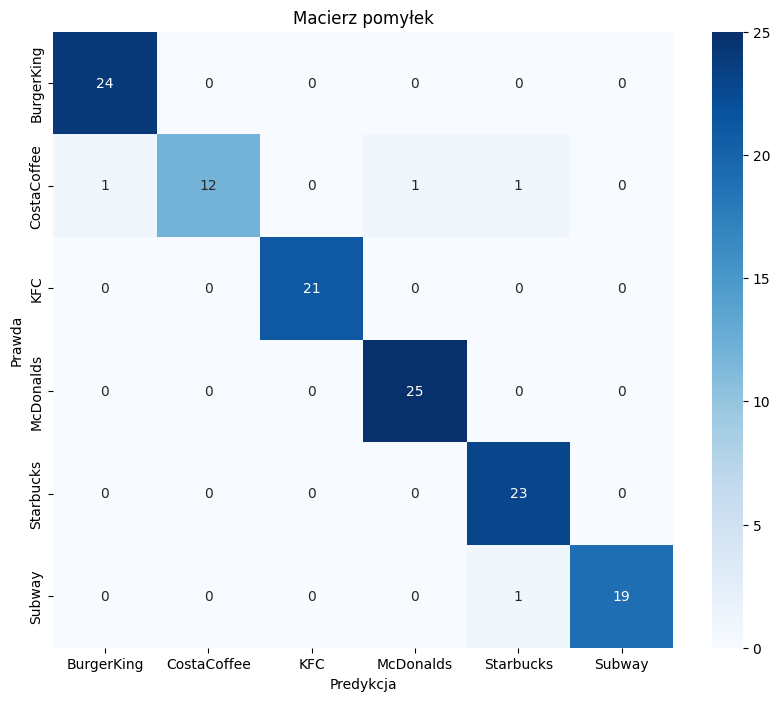


Raport klasyfikacji:

              precision    recall  f1-score   support

  BurgerKing       0.96      1.00      0.98        24
 CostaCoffee       1.00      0.80      0.89        15
         KFC       1.00      1.00      1.00        21
   McDonalds       0.96      1.00      0.98        25
   Starbucks       0.92      1.00      0.96        23
      Subway       1.00      0.95      0.97        20

    accuracy                           0.97       128
   macro avg       0.97      0.96      0.96       128
weighted avg       0.97      0.97      0.97       128



In [10]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

val_data.reset()

predykcje = model.predict(val_data, verbose=1)
klasyPredykcji = np.argmax(predykcje, axis=1)

klasyPrawdziwe = val_data.classes
nazwyKlas = list(val_data.class_indices.keys())

macierzPomylek = confusion_matrix(klasyPrawdziwe, klasyPredykcji)

plt.figure(figsize=(10, 8))
sns.heatmap(
    macierzPomylek,
    annot=True,
    fmt="d",
    xticklabels=nazwyKlas,
    yticklabels=nazwyKlas,
    cmap="Blues"
)
plt.xlabel("Predykcja")
plt.ylabel("Prawda")
plt.title("Macierz pomyłek")
plt.show()

print("\nRaport klasyfikacji:\n")
print(
    classification_report(
        klasyPrawdziwe,
        klasyPredykcji,
        target_names=nazwyKlas
    )
)


## Testowanie na obrazach testowy

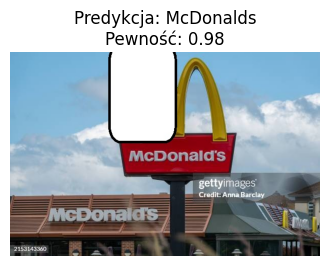

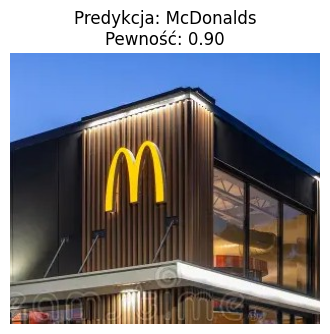

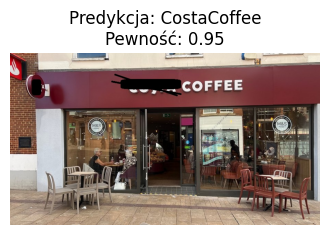

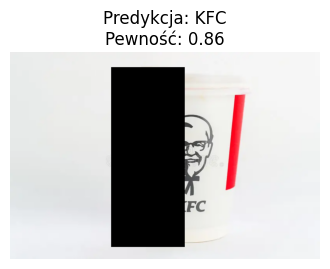

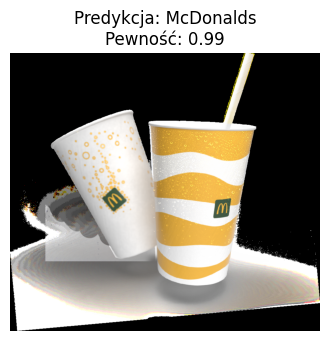

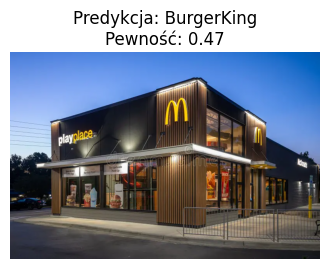

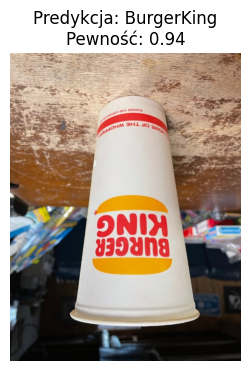

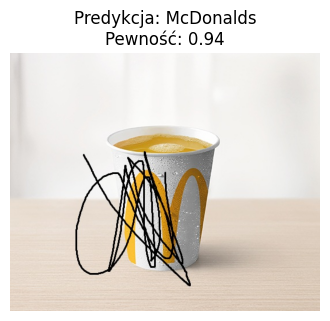

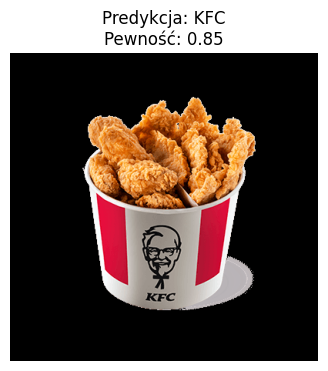

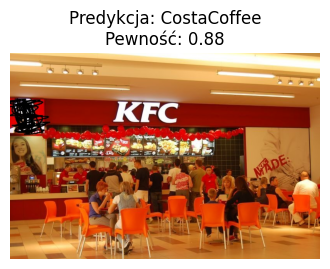

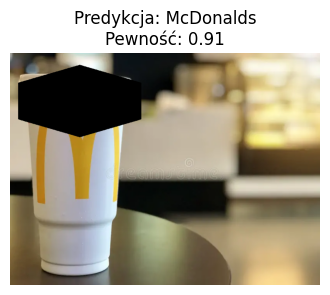

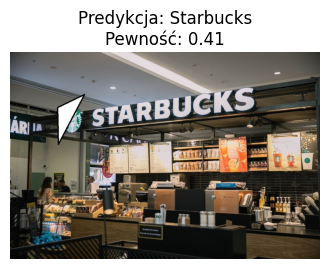

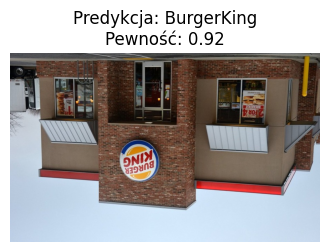

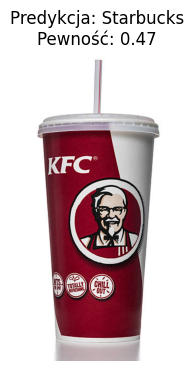

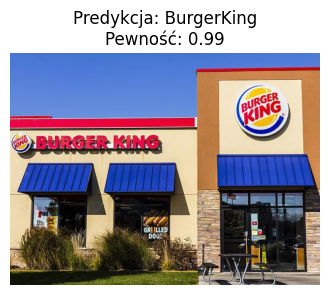

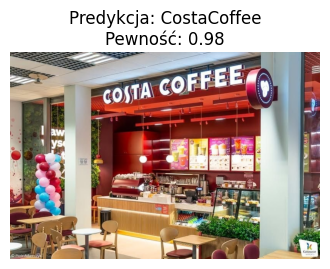

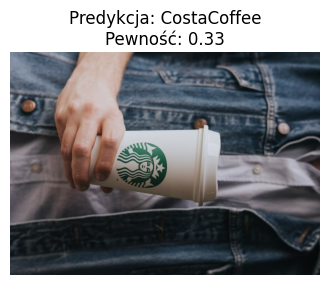

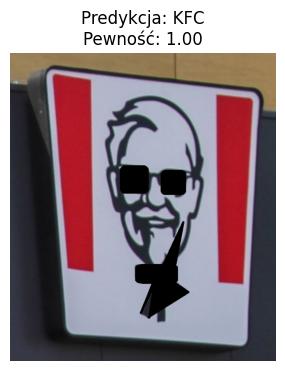

In [11]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import json
import tensorflow as tf
import os

SCIEZKA_MODELU = '/content/logotypyMarek.keras'
SCIEZKA_ETYKIET = '/content/labelsy.json'
SCIEZKA_TESTOW = '/content/testy'

model = tf.keras.models.load_model(SCIEZKA_MODELU)
with open(SCIEZKA_ETYKIET, 'r') as f:
    labels = json.load(f)

def przewidzLogo(sciezka):
    img = cv2.imread(sciezka)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    imgResized = cv2.resize(img, (224, 224))
    imgInput = preprocess_input(imgResized.astype(np.float32))
    imgInput = np.expand_dims(imgInput, axis=0)

    pred = model.predict(imgInput, verbose=0)[0]
    idx = np.argmax(pred)
    pewnosc = pred[idx]

    return img, labels[idx], pewnosc

for nazwaPliku in os.listdir(SCIEZKA_TESTOW):
    sciezka = os.path.join(SCIEZKA_TESTOW, nazwaPliku)

    img, klasa, pewnosc = przewidzLogo(sciezka)

    plt.figure(figsize=(4,4))
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Predykcja: {klasa}\nPewność: {pewnosc:.2f}")
    plt.show()


## Ładowanie obrazu w colabie

In [12]:
!pip install -q tensorflow opencv-python

import json, cv2, numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from google.colab import files

SCIEZKA_MODELU = '/content/logotypyMarek.keras'
SCIEZKA_ETYKIET = '/content/labelsy.json'
ROZMIAR_OBRAZU = (224, 224)

model = load_model(SCIEZKA_MODELU)
with open(SCIEZKA_ETYKIET, 'r') as f:
    labels = json.load(f)

print("Model i etykiety załadowane.")
print("Klasy:", labels)

print("\nWybierz obraz do rozpoznania:")
plik = files.upload()

for fname in plik.keys():
    img = cv2.imread(fname)
    if img is None:
        print(f"Nie udało się wczytać: {fname}")
        continue

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, ROZMIAR_OBRAZU)
    arr = np.expand_dims(img.astype('float32'), axis=0)
    arr = preprocess_input(arr)

    preds = model.predict(arr)[0]
    top3_idx = preds.argsort()[-3:][::-1]

    print(f"\nPlik: {fname}")
    for i in top3_idx:
        print(f"{labels[i]}: {preds[i]*100:.2f}%")
    print(f"Najbardziej prawdopodobna marka: {labels[top3_idx[0]]}")

Model i etykiety załadowane.
Klasy: ['BurgerKing', 'CostaCoffee', 'KFC', 'McDonalds', 'Starbucks', 'Subway']

Wybierz obraz do rozpoznania:


Saving res16.jpg to res16.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step

Plik: res16.jpg
Subway: 95.46%
KFC: 1.73%
McDonalds: 1.13%
Najbardziej prawdopodobna marka: Subway
